# Identifying  handwritten digits with a Quantum Support Vector Machine

Author: David Bucher 2018

The goal of this notebook is to have a functioning support vector machine based on the HHL algorithm, which can decide between handwritten 6s and 9s. First two features of the image are extracted from the digit images, namely the ratio between black pixels in the upper (left) and lower (right) half of the image. So we have two coordinates to represent a handwritten digit in the 'feature space'. The SVM is supposed find an optimal fence (hyperplane), which divides the two groups. The learning of the SVM is done via the HHL algorithm, because the least-squares approximation of the optimization of the hyperplane reduces to the problem of solving a system of linear equations.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg" width="300px"/>

One of the biggest drawbacks of the HHL is, that the result is encoded in a quantum state and, therefore, not directly accessible. However, the SVM only needs to classify unknown inputs into the two groups, that is telling on which side of fence the new data point lies. Thus, we can use the quantum computer as well for the classification calculation, using the quantum encoded result of the training.

This whole notebook is heavily based on the work of:
* [Li, Liu, Xu, Du: Experimental Realization of a Quantum Support Vector Machine](https://doi.org/10.1103/PhysRevLett.114.140504)
* [Rebentrost, Mohseni, Lloyd: Quantum support vector machine for big data classification](https://doi.org/10.1103/PhysRevLett.113.130503)
* [Harrow, Hassedim, Lloyd: Quantum algorithm for solving linear systems of equations](https://doi.org/10.1103/PhysRevLett.103.150502)

In [1]:
%load_ext autoreload
%autoreload 2
import ocr_prep as prep
import svm_base as svm
import numpy as np
from qiskit import execute, register
import Qconfig
import os
os.system("./install.sh")
#register(Qconfig.APItoken)
svm.MODE = 2

## Preprocessing

first the training data, as well as, the testing data is preprocessed, by calculating the ratios between black pixels in the upper (left) and lower (right) part of the image. Then a linear conversion happens to make them easier to use for our application and finally the vector is normalized to be representable by a qubit. The training data gets an additional label '-1' for the '6' and '1' for '9'.

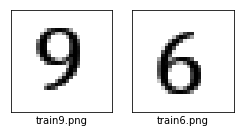

[(array([0.95253287, 0.30443576]), 1), (array([0.10366243, 0.99461254]), -1)]


In [2]:
training_set = ["train9.png", "train6.png"]
training_set = list(map(lambda x: os.path.join(prep.BASE_PATH, x), training_set))
#training_set = prep.get_random_set(n=2)
prep.display_images(training_set, title=False)

labels = {"-1": "6", "1": "9"}

training_data = prep.preprocess_images(training_set, labels=[1, -1])
print(training_data)

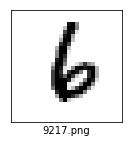

[array([0.25895356, 0.96588977])]


In [3]:
test_set = prep.get_random_set(n=1)
prep.display_images(test_set, title=False)

test_data = prep.preprocess_images(test_set)
print(test_data)

## Matrix generation

Rebentrost et. al. state a quantum algorithm which creates the matrix on the quantum computer and directly uses is to calculate its inverse. However due to viability problems, we choose a hybrid approach like Li et al. Here the matrix is generated and then reconstructed classically using state tomography. This matrix is also calculated classically, being $K_{ij} = \vec{x_i}\cdot\vec{x_j}$.

In [4]:
tomo_matrix = svm._construct_density_matrix2x2(training_data)
clas_matrix = np.array([[w[0].dot(v[0]) for w in training_data] for v in training_data])
clas_matrix = clas_matrix/np.trace(clas_matrix)
print("Construct classical matrix")
print(clas_matrix)
matrix = tomo_matrix

Construct Matrix via Tomography
[[0.50488281+0.j         0.20800781+0.01953125j]
 [0.20800781-0.01953125j 0.49511719+0.j        ]]
Construct classical matrix
[[0.5        0.20076875]
 [0.20076875 0.5       ]]


## Construction and execution of the circuit

The HHL algorithm is being constructed here. After its execution the circuit for finding the classification of the the testing data point is appended. The probability of measuring a specific qubit in $|0\rangle$ is then $\frac{1}{2}(1+\langle x | u \rangle)$, where the sign of $\langle x | u \rangle$ tells us the group the input belongs to. 

The HHL algorithm has a probability of failing, that means the first qubit measures $|0\rangle$. So all those counts are discarded. The difference between $|10\rangle$ and $|11\rangle$ should eventually give the demanded classification.

In [5]:
invec = svm.normalize([td[1] for td in training_data])
qc = svm._construct_hhl(matrix, invec=invec, evo_time=2*np.pi)
svm._construct_svm_expectation_value2x2(qc, training_data, test_data[0])
print("b =", invec)

b = [ 0.70710678 -0.70710678]


In [6]:
result = execute(qc, backend="local_qasm_simulator").result()
print(result)

COMPLETED


{'0 00 0': 7, '0 00 1': 6, '0 01 0': 2, '0 01 1': 30, '0 10 0': 18, '0 10 1': 11, '0 11 0': 9, '0 11 1': 3, '1 00 0': 42, '1 00 1': 184, '1 01 0': 13, '1 01 1': 81, '1 10 0': 173, '1 10 1': 124, '1 11 0': 295, '1 11 1': 26}


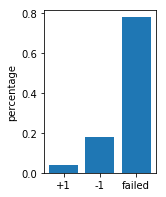

The digit is a 6


In [7]:
print(result.get_counts())
svm.plot_counts(result, [qc])
cla = svm.classify_results(result, [qc], test_data)
print("The digit is a", labels[str(cla[0][1])])

## Bulk testing

Here, the above code is tested far more testing samples. The upper cell generates a test_set and the lower cell classifies it.

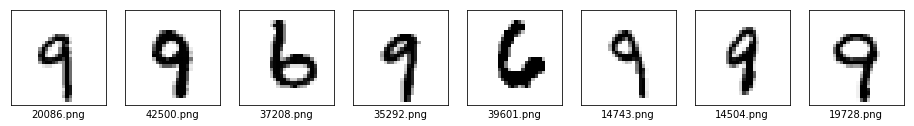

In [8]:
test_set_bulk = prep.get_random_set()
test_data_bulk = prep.preprocess_images(test_set_bulk)
fig, axes = prep.display_images(test_set_bulk, title=False)

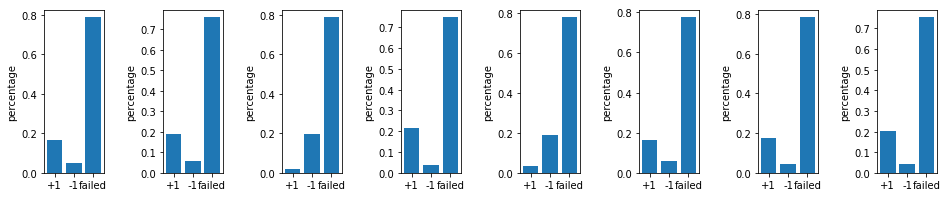

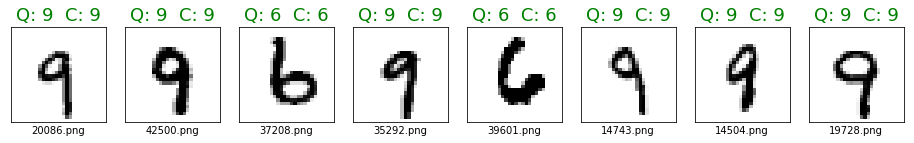

In [9]:
res = svm.classify(training_data, test_data_bulk, matrix=matrix, evo_time=2*np.pi, plot=True)
res2 = svm.classify_classically(training_data, test_data_bulk, matrix)
for ax, re, re2 in zip(axes, res, res2):
    ax.set_title("Q: " + labels[str(re[1])] + "  C: " + labels[str(re2[1])], size=18, color="red" if re[1] != re2[1] else "green")
fig

## The circuit

The abstract circuit looks like this:

![](img/circ/svm2.png)

The operators and states are defined like $U|0\rangle|\vec{\alpha}\rangle = |u\rangle$ and $V|0\rangle|0\rangle=|v\rangle$. The angles $\theta_i$ correspond to the feature vectors like $\theta_i = 2\arcsin\frac{x_i^1}{x_i^2}$. The subscript $x$ indicates the test-vector. So the full measuring process is basically  $\langle 00|V^{*T}|u\rangle=\langle v|u\rangle$. The controlling of $V^{*T}$ gives the probabilities $P_{0/1} = \frac{1}{2}(\langle00|u\rangle \pm \langle v|u\rangle)$ of measuring $|0\rangle$ ($|1\rangle$) in the second qubit, i.e. $P_0-P_1=\langle v|u\rangle$. [More on theory](svm_ocr_theoretical.ipynb)

The full qasm circuit is shown below:

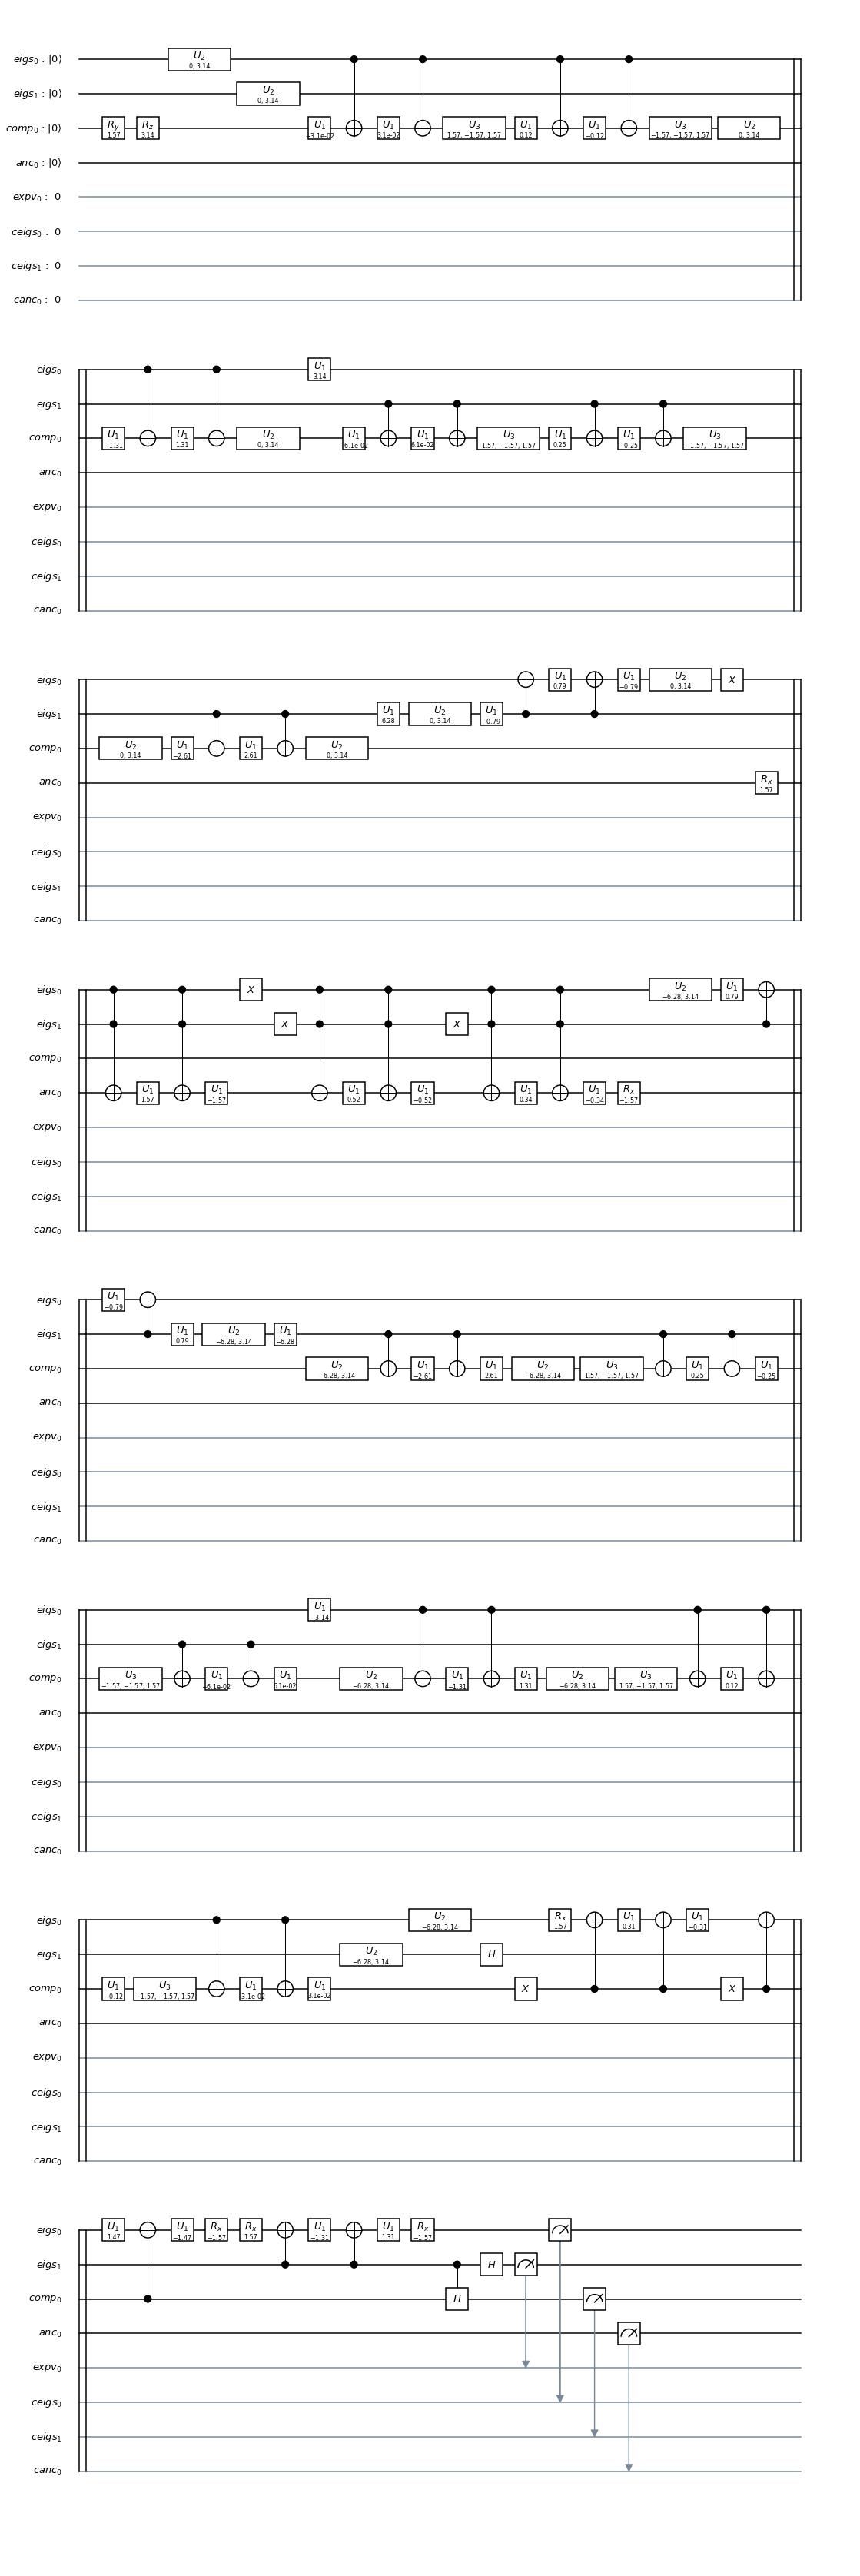

In [10]:
from qiskit.tools.visualization import matplotlib_circuit_drawer
matplotlib_circuit_drawer(qc)